In [10]:
from pathlib import Path
import joblib

import pandas as pd
import numpy as np
import joblib

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import BorderlineSMOTE

models_path = Path("../models")
base_path = Path("../datasets")

model_file = models_path / "churn_pipeline_lr-l1-bsmote-scaled-binned-v1.joblib"
dataset_file = base_path / "customer_churn.csv"

In [14]:
def add_days_onboard(df):
    ref_date = pd.Timestamp('2018-01-01')  # ou qualquer data que você usou no treinamento
    df = df.copy()
    df["Onboard_date"] = pd.to_datetime(df["Onboard_date"])
    df["Days_Onboard"] = (ref_date - df["Onboard_date"]).dt.days
    return df
    
pipeline = joblib.load(model_file)

In [11]:
if dataset_file.exists():
    df_orig = pd.read_csv(dataset_file)
    display(df_orig.head())
    display(df_orig.shape)
else:
    print(f"Arquivo não encontrado: {dataset_file.resolve()}")

,Names,Age,Total_Purchase,Account_Manager,Years,Num_Sites,Onboard_date,Location,Company,Churn
0,Cameron Williams,42.0,11066.80,0,7.22,8.0,2013-08-30 07:00:40,"10265 Elizabeth Mission Barkerburgh, AK 89518",Harvey LLC,1
1,Kevin Mueller,41.0,11916.22,0,6.50,11.0,2013-08-13 00:38:46,"6157 Frank Gardens Suite 019 Carloshaven, RI 1...",Wilson PLC,1
2,Eric Lozano,38.0,12884.75,0,6.67,12.0,2016-06-29 06:20:07,"1331 Keith Court Alyssahaven, DE 90114","Miller, Johnson and Wallace",1
3,Phillip White,42.0,8010.76,0,6.71,10.0,2014-04-22 12:43:12,"13120 Daniel Mount Angelabury, WY 30645-4695",Smith Inc,1
4,Cynthia Norton,37.0,9191.58,0,5.56,9.0,2016-01-19 15:31:15,"765 Tricia Row Karenshire, MH 71730",Love-Jones,1


(900, 10)

In [20]:
def predict_threshold(pipeline, X, threshold=0.5):
    """
    Faz a previsão com threshold customizado.
    
    Parâmetros:
        pipeline: pipeline treinado com método predict_proba.
        X: dados de entrada.
        threshold: ponto de corte para classificar como positivo.
    
    Retorna:
        y_pred: rótulos preditos com base no threshold.
        y_proba: probabilidades da classe positiva.
    """
    y_proba = pipeline.predict_proba(X)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)
    return y_pred, y_proba


In [21]:
X = df_orig.drop(columns=["Churn"])
y = df_orig["Churn"]

In [44]:
print(df_orig["Churn"].unique())
print(df_orig["Churn"].dtype)


[1 0]
int64


<Figure size 600x400 with 0 Axes>

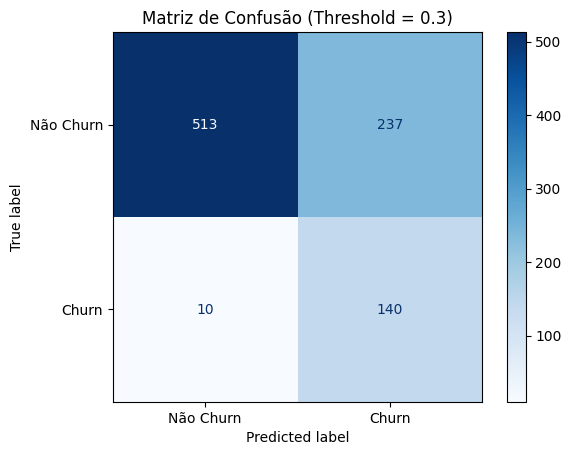

📊 Classification Report (Threshold = 0.3):

              precision    recall  f1-score   support

           0     0.9809    0.6840    0.8060       750
           1     0.3714    0.9333    0.5313       150

    accuracy                         0.7256       900
   macro avg     0.6761    0.8087    0.6686       900
weighted avg     0.8793    0.7256    0.7602       900



In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Previsão com threshold customizado
threshold = 0.3
y_pred, y_proba = predict_threshold(pipeline_val, X, threshold)

# 1. Matriz de Confusão
plt.figure(figsize=(6, 4))
ConfusionMatrixDisplay.from_predictions(
    y, y_pred, display_labels=["Não Churn", "Churn"], cmap="Blues", values_format='d'
)
plt.title(f"Matriz de Confusão (Threshold = {threshold})")
plt.grid(False)
plt.show()


# 2. Métricas de Classificação
print(f"📊 Classification Report (Threshold = {threshold}):\n")
print(classification_report(y, y_pred, digits=4))

In [ ]:
total = len(y)
churned = y.sum()
print(f"{churned} de {total} clientes fizeram churn ({churn_rate:.2f}%)")

📈 Porcentagem de clientes que fizeram churn: 16.67%
150 de 900 clientes fizeram churn (16.67%)


In [47]:
# Total de clientes com Account Manager
clientes_com_am = df_orig[df_orig["Account_Manager"] == 1].shape[0]
total_clientes = df_orig.shape[0]

# Porcentagem
perc_com_am = (clientes_com_am / total_clientes) * 100

print(f"👥 Clientes com Account Manager: {clientes_com_am} de {total_clientes}")
print(f"📊 Cobertura de Account Manager: {perc_com_am:.2f}%")


👥 Clientes com Account Manager: 433 de 900
📊 Cobertura de Account Manager: 48.11%


In [34]:
# Total de churns
total_churn = df_orig[df_orig["Churn"] == 1].shape[0]

# Churns com Account Manager
churn_com_am = df_orig[(df_orig["Churn"] == 1) & (df_orig["Account_Manager"] == 1)].shape[0]

# Porcentagem sobre o total de churn
perc_churn_am = (churn_com_am / total_churn) * 100 if total_churn > 0 else 0

print(f"Total de churns: {total_churn}")
print(f"Churns com Account Manager: {churn_com_am}")
print(f"🔍 {perc_churn_am:.2f}% dos churns tinham Account Manager")


Total de churns: 150
Churns com Account Manager: 84
🔍 56.00% dos churns tinham Account Manager


In [ ]:
# Garantir alinhamento
df_orig = df_orig.loc[X.index]

# Prever com threshold = 0.3
y_pred, _ = predict_threshold(pipeline, X, threshold=0.3)

# Falsos positivos: previu churn, mas é não churn
fp_mask = (y_pred == 1) & (df_orig["Churn"] == 0)
falsos_positivos = df_orig[fp_mask]

# Contagens
total_fp = falsos_positivos.shape[0]
com_am = falsos_positivos[falsos_positivos["Account_Manager"] == 1].shape[0]
sem_am = falsos_positivos[falsos_positivos["Account_Manager"] == 0].shape[0]

print(f"🔍 Total não churn preditos como churn: {total_fp}")
print(f" - Com Account Manager: {com_am}")
print(f" - Sem Account Manager: {sem_am}")

🔍 Total não churn preditos como churn: 237
 - Com Account Manager: 121
 - Sem Account Manager: 116


In [48]:
# Alinhar índice para segurança
df_orig_aligned = df_orig.loc[X.index]

# Obter predições com threshold ajustado
y_pred, y_proba = predict_threshold(pipeline, X, threshold=0.3)

# Falsos positivos: previu churn mas não é churn
fp_mask = (y_pred == 1) & (df_orig_aligned["Churn"] == 0)
falsos_positivos = df_orig_aligned[fp_mask].copy()
falsos_positivos["Pred_Prob"] = y_proba[fp_mask]

# Convertendo Onboard_date
falsos_positivos["Onboard_date"] = pd.to_datetime(falsos_positivos["Onboard_date"])

# Top 10 clientes por valor
top_valor = falsos_positivos.sort_values(by="Total_Purchase", ascending=False).head(10)

# Top 10 clientes mais antigos
top_antigos = falsos_positivos.sort_values(by="Onboard_date").head(10)

print("💰 Top 10 falsos positivos com maior Total_Purchase:\n")
display(top_valor[["Company", "Total_Purchase", "Onboard_date", "Account_Manager", "Pred_Prob"]])

print("\n⏳ Top 10 falsos positivos com onboarding mais antigo:\n")
display(top_antigos[["Company", "Total_Purchase", "Onboard_date", "Account_Manager", "Pred_Prob"]])


💰 Top 10 falsos positivos com maior Total_Purchase:



,Company,Total_Purchase,Onboard_date,Account_Manager,Pred_Prob
818,White-Thomas,16371.42,2014-12-18 16:51:16,1,0.536336
150,Petty and Sons,15571.26,2011-12-02 20:13:49,0,0.377265
354,Wright Group,15516.52,2016-01-07 07:31:58,0,0.416718
292,"Blanchard, Hawkins and Torres",14715.53,2014-01-31 00:05:00,1,0.392662
372,Wright Ltd,14669.61,2012-08-30 14:53:07,0,0.655586
536,"Hill, Abbott and Wu",14595.51,2007-01-02 22:09:08,1,0.863120
242,Anderson-Evans,14242.70,2009-06-09 07:44:13,0,0.667169
665,Robinson-Perez,14241.75,2006-07-11 11:32:51,0,0.864261
309,Cantu Inc,14154.26,2012-08-19 15:56:39,0,0.308877
662,"Rocha, Wagner and Chandler",14124.00,2014-12-17 02:27:36,1,0.514289



⏳ Top 10 falsos positivos com onboarding mais antigo:



,Company,Total_Purchase,Onboard_date,Account_Manager,Pred_Prob
159,Davis-Travis,10309.15,2006-01-10 18:04:20,1,0.588140
471,Finley-Moore,9347.47,2006-01-23 16:23:17,0,0.337984
588,Pearson-Gonzales,10565.59,2006-01-28 01:22:53,0,0.465828
353,"Smith, Moran and Gonzales",11321.20,2006-03-07 00:11:21,0,0.691504
346,"Jones, Black and Schneider",10877.81,2006-05-10 04:40:16,1,0.707076
853,Price-Webb,9451.03,2006-06-28 17:50:11,0,0.610378
665,Robinson-Perez,14241.75,2006-07-11 11:32:51,0,0.864261
206,Murphy Inc,13157.08,2006-08-14 09:24:11,1,0.390765
310,Ortiz Ltd,10583.76,2006-08-18 05:47:20,0,0.523162
215,"Moreno, Green and Moreno",9940.76,2006-08-28 11:16:01,0,0.945367


In [49]:
# Obter os nomes das empresas nos dois grupos
empresas_top_valor = set(top_valor["Company"])
empresas_top_antigos = set(top_antigos["Company"])

# Interseção entre os dois grupos
empresas_em_ambos = empresas_top_valor & empresas_top_antigos

# Exibir os dados cruzados
cruzados = falsos_positivos[falsos_positivos["Company"].isin(empresas_em_ambos)]

print(f"🔎 Clientes que estão entre os mais valiosos E mais antigos (total: {len(cruzados)}):\n")
display(cruzados[["Company", "Total_Purchase", "Onboard_date", "Account_Manager", "Pred_Prob"]])


🔎 Clientes que estão entre os mais valiosos E mais antigos (total: 1):



,Company,Total_Purchase,Onboard_date,Account_Manager,Pred_Prob
665,Robinson-Perez,14241.75,2006-07-11 11:32:51,0,0.864261


# 📘 Relatório Executivo – Análise de Retenção e Atuação dos Account Managers

## 1. Visão Geral

Este relatório apresenta os principais achados da análise preditiva de churn (cancelamento de clientes) e o papel atual dos Account Managers (AMs) na retenção da base. O estudo utilizou modelos baseados em dados históricos para identificar clientes com maior risco de cancelamento e avaliar a efetividade das estratégias atuais de relacionamento.

---

## 2. Principais Indicadores

- 👥 **Clientes atualmente com Account Manager**: 433 de 900  
- 📈 **Cobertura atual de AMs**: 48,11%

- 🔻 **Total de clientes que cancelaram**: 150  
- 🔸 **Clientes que cancelaram mesmo com Account Manager**: 84  
  ➤ Representando **56% de todos os cancelamentos**

- ⚠️ **Clientes que ainda não cancelaram, mas foram identificados como alto risco**: 237  
  - Destes:
    - ✅ Possuem Account Manager: 121
    - ❌ Não possuem Account Manager: 116

---

## 3. Avaliação e Diagnóstico

Os dados mostram que **mais da metade dos cancelamentos ocorreram com clientes que já tinham Account Manager designado**, indicando que o acompanhamento atual pode não estar sendo suficiente para reter clientes em risco.

Além disso, há **237 clientes que ainda estão ativos, mas foram identificados como com alto risco de cancelamento**. Esta é uma oportunidade clara de atuação preventiva, principalmente considerando que muitos desses clientes são financeiramente relevantes e têm um longo relacionamento com a empresa.

---

## 4. Ações Recomendadas

### 4.1. Reforço Imediato na Capacitação dos Account Managers

Sugere-se a implementação de um programa de desenvolvimento com foco em:

- Identificação de sinais de risco nos clientes
- Ações proativas de retenção
- Estratégias de engajamento personalizadas
- Acesso a informações estratégicas para tomada de decisão

### 4.2. Implantação de Ferramentas de Apoio à Decisão

É essencial oferecer aos AMs ferramentas analíticas que permitam:

- Monitorar clientes com risco elevado de cancelamento
- Visualizar indicadores-chave de relacionamento e engajamento
- Priorizar o atendimento com base no valor e histórico do cliente

### 4.3. Reorganização da Alocação dos Account Managers

Com base nos achados:

- Focar imediatamente nos **121 clientes com AM que estão em situação de risco**
- Designar AMs disponíveis ou com menor carga para os **116 clientes críticos ainda sem acompanhamento**
- Estabelecer critérios objetivos para a alocação de AMs, combinando risco, valor financeiro e tempo de relacionamento

---

## 5. Clientes Estratégicos em Risco

### 💰 Top 10 clientes com maior volume de compras em risco

| ID  | Company                              | Total_Purchase | Onboard_date           | Account_Manager | Pred_Prob |
|-----|--------------------------------------|----------------|------------------------|-----------------|------------|
| 818 | White-Thomas                         | 16,371.42      | 2014-12-18 16:51:16    | 1               | 0.5363     |
| 150 | Petty and Sons                       | 15,571.26      | 2011-12-02 20:13:49    | 0               | 0.3773     |
| 354 | Wright Group                         | 15,516.52      | 2016-01-07 07:31:58    | 0               | 0.4167     |
| 292 | Blanchard, Hawkins and Torres        | 14,715.53      | 2014-01-31 00:05:00    | 1               | 0.3927     |
| 372 | Wright Ltd                           | 14,669.61      | 2012-08-30 14:53:07    | 0               | 0.6556     |
| 536 | Hill, Abbott and Wu                  | 14,595.51      | 2007-01-02 22:09:08    | 1               | 0.8631     |
| 242 | Anderson-Evans                       | 14,242.70      | 2009-06-09 07:44:13    | 0               | 0.6672     |
| 665 | Robinson-Perez                       | 14,241.75      | 2006-07-11 11:32:51    | 0               | 0.8643     |
| 309 | Cantu Inc                            | 14,154.26      | 2012-08-19 15:56:39    | 0               | 0.3089     |
| 662 | Rocha, Wagner and Chandler           | 14,124.00      | 2014-12-17 02:27:36    | 1               | 0.5143     |

### ⏳ Top 10 clientes com mais tempo sem contato, também em risco

| ID  | Company                              | Total_Purchase | Onboard_date           | Account_Manager | Pred_Prob |
|-----|--------------------------------------|----------------|------------------------|-----------------|------------|
| 159 | Davis-Travis                         | 10,309.15      | 2006-01-10 18:04:20    | 1               | 0.5881     |
| 471 | Finley-Moore                         | 9,347.47       | 2006-01-23 16:23:17    | 0               | 0.3380     |
| 588 | Pearson-Gonzales                     | 10,565.59      | 2006-01-28 01:22:53    | 0               | 0.4658     |
| 353 | Smith, Moran and Gonzales            | 11,321.20      | 2006-03-07 00:11:21    | 0               | 0.6915     |
| 346 | Jones, Black and Schneider           | 10,877.81      | 2006-05-10 04:40:16    | 1               | 0.7071     |
| 853 | Price-Webb                           | 9,451.03       | 2006-06-28 17:50:11    | 0               | 0.6104     |
| 665 | Robinson-Perez                       | 14,241.75      | 2006-07-11 11:32:51    | 0               | 0.8643     |
| 206 | Murphy Inc                           | 13,157.08      | 2006-08-14 09:24:11    | 1               | 0.3908     |
| 310 | Ortiz Ltd                            | 10,583.76      | 2006-08-18 05:47:20    | 0               | 0.5232     |
| 215 | Moreno, Green and Moreno             | 9,940.76       | 2006-08-28 11:16:01    | 0               | 0.9454     |

### 🔎 Cliente de máxima prioridade (em ambas as listas)

| ID  | Company              | Total_Purchase | Onboard_date           | Account_Manager | Pred_Prob |
|-----|----------------------|----------------|------------------------|-----------------|------------|
| 665 | Robinson-Perez       | 14,241.75      | 2006-07-11 11:32:51    | 0               | 0.8643     |

---

## 6. Conclusão Executiva

A análise deixa claro que há **vulnerabilidades na estratégia atual de relacionamento com clientes**. O número expressivo de clientes em risco — mesmo entre aqueles com Account Manager — mostra a necessidade urgente de mudança.

Recomenda-se à diretoria:

- Investir com urgência na **capacitação dos Account Managers**
- Disponibilizar ferramentas que auxiliem na priorização e monitoramento da base
- Adotar uma abordagem proativa com os clientes identificados como mais propensos a cancelar, **antes que a perda se concretize**

Ignorar esses sinais pode gerar perdas financeiras evitáveis. Ao agir de forma estruturada e orientada por dados, a empresa terá a oportunidade de **reduzir o cancelamento de clientes, proteger sua receita e fortalecer o papel dos AMs como peças-chave na fidelização da base**.

---

## 7. Próximos Passos Estratégicos

### 7.1. Dashboard Operacional de Retenção – *Radar de Retenção*

Criação de um painel em tempo real para monitoramento de KPIs críticos:

- 🔄 Churn atual  
- 🔮 Previsão de churn (média e distribuição)  
- 👥 Cobertura de AMs sobre clientes em risco  
- 🏷️ Top clientes em risco (por valor e tempo de casa)  
- ⌛ Tempo médio desde último contato  
- 🛠️ Ações executadas com base nas predições  
- 📈 Performance de retenção por AM  

---

### 7.2. Implementação do Modelo Preditivo em Produto

Para garantir que a inteligência de churn gere impacto real, recomenda-se a **implantação do modelo em ambiente produtivo**, com integração direta aos sistemas atuais de vendas e CRM.

Essa implementação deve contemplar:

- 🔌 **API de predição integrada ao CRM e pipeline de vendas**, permitindo que a probabilidade de churn seja consultada automaticamente pelos times comerciais e de sucesso do cliente.  
- 🔁 **Atualização periódica do modelo com dados recentes**, assegurando acurácia e adaptação contínua aos padrões de comportamento dos clientes.  
- 🧠 **Monitoramento de performance e versionamento do modelo**, garantindo segurança e transparência nas decisões automatizadas.  
- 📡 **Notificações e alertas automatizados** para priorização de atendimento a clientes em risco, com possibilidade de integração com ferramentas como e-mail, Slack ou sistemas internos.  

Essa arquitetura permitirá decisões mais rápidas, priorização eficiente e atuação proativa — tudo isso sem fricção nos processos comerciais existentes.

---

### 7.3. Integração com Time Comercial e Sucesso do Cliente

- 📬 Alertas semanais para AMs com lista de clientes em risco  
- 🧑‍💼 Reuniões quinzenais de revisão com liderança comercial  
- 🎯 Metas e OKRs de retenção alinhados com o modelo preditivo  
- 📚 Playbooks com ações táticas por segmento e probabilidade  
- 🔄 Feedback contínuo das ações realizadas para melhoria do modelo  

---
